In [1]:
from extract import SocialETL, construct_query_for_twarc, extract_tags, SocialDB, UserETL
import hashtags as h
import hashtags_readcsv as r_csv
import pandas as pd
import numpy as np
import json
import statistics
import networkx as nx
from numpy import nan

# 1) Download DF

In [2]:
#modifiche: cambiare data e togliere lang eng
m = SocialETL(query="(#covid OR #pridemonth OR #grammys OR #justiceforjohnnydepp OR #putin OR #russia OR #ukraine OR #war)", pages=1500, recent=False) #strangerthings4 

Output()

rate limit exceeded: sleeping 112.45554637908936 secs
rate limit exceeded: sleeping 112.62277436256409 secs
rate limit exceeded: sleeping 93.62968969345093 secs
rate limit exceeded: sleeping 62.28101181983948 secs


In [3]:
m.df.shape

(149806, 74)

In [4]:
m.df=m.df.dropna(subset=['entities.hashtags'])
m.df=m.df.dropna(subset=['retweeted_user_id'])

In [5]:
m.df['entities.hashtags']=m.df['entities.hashtags'].apply(eval)
m.df['entities.hashtags']=m.df['entities.hashtags'].map(h.extract_tags)
#m.df['retweeted_user_id']=m.df['retweeted_user_id'].tolist()
#m.df['conversation_id']=m.df['conversation_id'].tolist()
#m.df['author.location']=m.df['author.location'].tolist()
#m.df['author.verified']=m.df['author.verified'].tolist()
#m.df['id']=m.df['id'].tolist()

In [6]:
#create a pandas dataframe
df_nodes=pd.DataFrame({"user_id":m.df['author_id'],
                       'tweet_id':m.df['id'],
                      'retweet_id': m.df['retweeted_user_id'],
                       'conversation_id':m.df['conversation_id'],
                      "hashtag":m.df['entities.hashtags'],
                     'location':m.df['author.location'],
                     'verified':m.df['author.verified']})

In [7]:
df_nodes['user_id']=df_nodes['user_id'].map(int)
df_nodes['hashtag']=df_nodes['hashtag'].map(str).apply(eval)
df_nodes['tweet_id']=df_nodes['tweet_id'].map(str).apply(eval)
df_nodes['conversation_id']=df_nodes['conversation_id'].map(str).apply(eval)
df_nodes['retweet_id']=df_nodes['retweet_id'].map(str).apply(eval)
df_nodes['location']=df_nodes['location'].map(str)#.apply(eval)
df_nodes['verified']=df_nodes['verified'].map(str).apply(eval)

In [8]:
df_nodes.set_index('user_id',inplace=True)

In [9]:
df_nodes.shape

(110878, 6)

In [10]:
df_nodes.head(3)

tweet_id           retweet_id  \
user_id                                                         
1497950696444141570  1561990065391296512  1356158825825525761   
2943739141           1561990057019723776   734631957238296576   
147306719            1561990051059351553           2749315621   

                         conversation_id                   hashtag  \
user_id                                                              
1497950696444141570  1561990065391296512                 [ukraine]   
2943739141           1561990057019723776              [covid, nsw]   
147306719            1561990051059351553  [ukraine, armukrainenow]   

                             location  verified  
user_id                                          
1497950696444141570               nan     False  
2943739141                  Australia     False  
147306719            Вінниця, Україна     False

## preprocessing 

In [11]:
#convert nested lists on set
def to_sets(nested_lists): 
    outer_list = set()
    for el in nested_lists: 
        if type(el) == list: 
            outer_list.update(el) 
        else: 
            outer_list.add(el)
    return outer_list
df_nodes['hashtag']=df_nodes['hashtag'].map(to_sets)
#df_nodes['retweet_id']=df_nodes['retweet_id'].map(to_sets)

In [12]:
#df_nodes['hashtag']=df_nodes['hashtag'].map(to_sets)
#df_nodes['tweet_id']=df_nodes['tweet_id'].apply(to_sets2)
#df_nodes['conversation_id']=df_nodes['conversation_id'].map(to_sets2)
#df_nodes['retweet_id']=df_nodes['retweet_id'].str.map(set)
#df_nodes['verified']=df_nodes['verified'].map(to_sets2)
#df_nodes['location']=df_nodes['location'].map(to_sets2)

In [13]:
df_nodes.head(3)

tweet_id           retweet_id  \
user_id                                                         
1497950696444141570  1561990065391296512  1356158825825525761   
2943739141           1561990057019723776   734631957238296576   
147306719            1561990051059351553           2749315621   

                         conversation_id                   hashtag  \
user_id                                                              
1497950696444141570  1561990065391296512                 {ukraine}   
2943739141           1561990057019723776              {covid, nsw}   
147306719            1561990051059351553  {ukraine, armukrainenow}   

                             location  verified  
user_id                                          
1497950696444141570               nan     False  
2943739141                  Australia     False  
147306719            Вінниця, Україна     False

In [14]:
df_nodes.shape

(110878, 6)

In [15]:
#df_nodes.to_csv('df_nodes')

# 2) Categorizzazione utenti

In [16]:
with open('hashtags_300.json', 'r') as f:
    my_dict = json.load(f)

In [17]:
proukr=set()
prorus=set()
pax=set()
for k,v in my_dict.items():
    for e in v:
        if k=='proukr':
            proukr.update(e)
        elif k=='pax':
            pax.update(e)
        elif k=='prorus':
            prorus.update(e)

In [18]:
cat=set.union(proukr,prorus,pax)
count1=0
count4=0
index1=[]
index4=[]

for i, row in enumerate(df_nodes['hashtag']): 
    if row.intersection(cat)==set():#no intersezione   
        #print(row.intersectionn(cat))
        #print("l'utente {}  appartiene alla 4 categoria".format(row.intersection(cat)))
        #print("4 categoria", row)
        count4 += 1
        index4.append(df_nodes.index[i])
        
    else: #c'è intersezione: uno della 3 categorie
        #print("non è la 4 categoria perchè contiene",row.intersection(cat))
       # if row.intersection(proukr)!=set(): #c'è intersez con proukr
            count1 += 1
            index1.append(i) #aggiungo alle rige da tgliere
            #print("l'utente {} non  appartiene alla 4 categoria perchè usa {}".format(df_nodes.index[i],row.intersection(cat)))

In [19]:
print('nocare = {} \n'
      'altre categorie = {}'.format(count4, count1))

nocare = 14244 
altre categorie = 96634


In [20]:
df_nodes['cat']=pd.NA
for i in index4:
    df_nodes['cat'].loc[i]='nocare'

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

In [21]:
df_nodes['cat'].fillna('war')

user_id
1497950696444141570       war
2943739141             nocare
147306719                 war
4164080487                war
1513463895641542662       war
                        ...  
1006267924561252355       war
2600371044                war
2781190880                war
450325992                 war
635702537                 war
Name: cat, Length: 110878, dtype: object

In [32]:
df_nodes['cat']=df_nodes['cat'].fillna('war')
df_nodes['cat']

user_id
1497950696444141570       war
2943739141             nocare
147306719                 war
4164080487                war
1513463895641542662       war
                        ...  
1006267924561252355       war
2600371044                war
2781190880                war
450325992                 war
635702537                 war
Name: cat, Length: 110878, dtype: object

In [36]:
df_nodes

tweet_id           retweet_id  \
user_id                                                         
1497950696444141570  1561990065391296512  1356158825825525761   
2943739141           1561990057019723776   734631957238296576   
147306719            1561990051059351553           2749315621   
4164080487           1561990050698743808  1234060130574049281   
1513463895641542662  1561990040988909570  1356158825825525761   
...                                  ...                  ...   
1006267924561252355  1561451149458378756            464644581   
2600371044           1561451147889901568           3160691427   
2781190880           1561451147403091969            255690491   
450325992            1561451139866021893  1222894323152195586   
635702537            1561451137349595136            114718372   

                         conversation_id  \
user_id                                    
1497950696444141570  1561990065391296512   
2943739141           1561990057019723776   
147306719            1561990051059351553   
4164080487           1561990050698743808   
1513463895641542662  1561990040988909570   
...                                  ...   
1006267924561252355  1561451149458378756   
2600371044           1561451147889901568   
2781190880           1561451147403091969   
450325992            1561451139866021893   
635702537            1561451137349595136   

                                                       hashtag  \
user_id                                                          
1497950696444141570                                  {ukraine}   
2943739141                                        {covid, nsw}   
147306719                             {ukraine, armukrainenow}   
4164080487                                 {putin, sannamarin}   
1513463895641542662                                  {ukraine}   
...                                                        ...   
1006267924561252355  {wohlstand, china, putin, lebensstandard}   
2600371044                                 {douguine, ukraine}   
2781190880                                     {russia, dugin}   
450325992                                 {china, ukraine, us}   
635702537                                    {russia, uk, g20}   

                                location  verified     cat  
user_id                                                     
1497950696444141570                  nan     False     war  
2943739141                     Australia     False  nocare  
147306719               Вінниця, Україна     False     war  
4164080487              Essen/Regensburg     False     war  
1513463895641542662                  nan     False     war  
...                                  ...       ...     ...  
1006267924561252355  Deutschland, Bayern     False     war  
2600371044                           nan     False     war  
2781190880               Kaduna, Nigeria     False     war  
450325992                       CT,  USA     False     war  
635702537                            nan     False     war  

[110878 rows x 7 columns]

# 3 Creazione rete

In [22]:
#df_nodes['location']=df_nodes['location'].map(list)

In [59]:
G = nx.Graph()
g= list(df_nodes.index)
cat=list(df_nodes['cat'])
G.add_nodes_from(g, clas=cat[i])#, verfied=''.join(str(i) for i in df_nodes['verified'][i])) # ,loc=df_nodes['location'][i], verfied=df_nodes['verified'][i])
list(G.nodes.data())

[(1497950696444141570, {'clas': 'war'}),
 (2943739141, {'clas': 'war'}),
 (147306719, {'clas': 'war'}),
 (4164080487, {'clas': 'war'}),
 (1513463895641542662, {'clas': 'war'}),
 (452876288, {'clas': 'war'}),
 (729172068, {'clas': 'war'}),
 (1213466498250891265, {'clas': 'war'}),
 (3134958427, {'clas': 'war'}),
 (1441795777366409221, {'clas': 'war'}),
 (1315970255705997312, {'clas': 'war'}),
 (1172900353228062720, {'clas': 'war'}),
 (1500004498378752004, {'clas': 'war'}),
 (775634466727485440, {'clas': 'war'}),
 (1518948022570438657, {'clas': 'war'}),
 (1315256704192442368, {'clas': 'war'}),
 (4581576017, {'clas': 'war'}),
 (3459673948, {'clas': 'war'}),
 (1665865950, {'clas': 'war'}),
 (470614581, {'clas': 'war'}),
 (1111179646538842112, {'clas': 'war'}),
 (254463061, {'clas': 'war'}),
 (1208819873792634880, {'clas': 'war'}),
 (1559852150410592256, {'clas': 'war'}),
 (2801360028, {'clas': 'war'}),
 (1514215204464300033, {'clas': 'war'}),
 (872917243390283776, {'clas': 'war'}),
 (148214

In [24]:
#link retweet
list_edges=[]
for u, user in enumerate(df_nodes.index):
    #print('u',user, type(user))
    for r,ret in enumerate(df_nodes['retweet_id']):
        #print('ret',ret, type(ret))
        if user==ret and user!=df_nodes.index[r]:
            #print('ok')
            #print('user {u} compare nei retweet di ',.format(u,df_nodes.index[i])
            list_edges.append({'from':user,
                               'to':df_nodes.index[r]})
print(len(list_edges))

151111


In [61]:
#add weights: how many times one tweet's user is twetted by an user
edges=[(x["from"], x["to"]) for x in list_edges]
#print(edges)
G.add_edges_from(edges)

In [62]:
G.remove_edges_from(list(nx.selfloop_edges(G)))
G.remove_nodes_from(list(nx.isolates(G)))

number of nodes = 23167 , number of edges = 27206 . number of components = 373


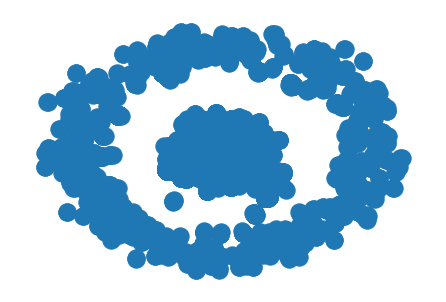

In [28]:
c=0
for component in list(nx.connected_components(G)):
    c += 1
nx.draw(G)
print('number of nodes =',G.number_of_nodes(),', number of edges =', G.number_of_edges(),'. number of components =',c) 

In [63]:
for component in list(nx.connected_components(G)):
    c += 1
    if len(component)<5000:
        for node in component:
            G.remove_node(node)

number of nodes = 21502 , number of edges = 25876 . number of components = 1


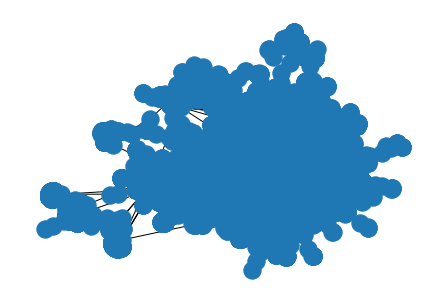

In [64]:
c=0
for component in list(nx.connected_components(G)):
    c += 1
nx.draw(G)
print('number of nodes =',G.number_of_nodes(),', number of edges =', G.number_of_edges(),'. number of components =',c) 

In [66]:
nx.write_gexf(G,'net with 1500 PAGES from m.df removing comp less 5000.gexf')

In [69]:
l_from=[]
l_to=[]
for e in list_edges:
    for k,v in e.items():
        if k=='from':
            l_from.append(v)
        if k=='to':
            l_to.append(v)

In [70]:
df=pd.DataFrame({'from':l_from,
                'to':l_to})
df.shape

(151111, 2)

In [71]:
df_weighted = df.value_counts().to_frame("weights").reset_index()

In [72]:
df_weighted

from                   to  weights
0                237785012   962663499129409540     8904
1       962663499129409540            237785012     8881
2      1151202637582348294  1556938545696309248     2537
3      1216550422191587328   749264747464429569     1064
4      1531989101548904448  1499795912515895305     1054
...                    ...                  ...      ...
27236            243983947  1272782207833108480        1
27237            243983947  1276420486474403840        1
27238            243983947  1279783434278166534        1
27239            243983947  1281188424376971265        1
27240  1561774510139125761  1151202637582348294        1

[27241 rows x 3 columns]

In [74]:
df_weighted["weights"] = (df_weighted["weights"] - (df_weighted["weights"]).min())/((df_weighted["weights"].max()-(df_weighted["weights"]).min()))

In [75]:
df_weighted

from                   to   weights
0                237785012   962663499129409540  1.000000
1       962663499129409540            237785012  0.997417
2      1151202637582348294  1556938545696309248  0.284848
3      1216550422191587328   749264747464429569  0.119398
4      1531989101548904448  1499795912515895305  0.118275
...                    ...                  ...       ...
27236            243983947  1272782207833108480  0.000000
27237            243983947  1276420486474403840  0.000000
27238            243983947  1279783434278166534  0.000000
27239            243983947  1281188424376971265  0.000000
27240  1561774510139125761  1151202637582348294  0.000000

[27241 rows x 3 columns]

In [77]:
df_weighted.to_csv('df_weighted')